In [132]:
import numpy as np
import pandas as pd
import urllib.request
import zipfile
import os
import re
import datetime
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import shutil
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import sys
path_to_zip_file = 'votes_detail_data.zip'
directory_name_for_voting_dataset = 'votesdetail'
path_to_taipeicity_sheet = directory_name_for_voting_dataset+'/taipeicity.xls'
path_to_register_votes_sheet = 'register_votes_result_data.xlsx'
#先抓取資料
register_votes_result_data_url = 'http://db.cec.gov.tw/histFile?voteCode=20181101A1B1&resourceCode=F1'
votes_detail_data = 'http://db.cec.gov.tw/histFile?voteCode=20181101A1B1&resourceCode=E1'
urllib.request.urlretrieve(register_votes_result_data_url, path_to_register_votes_sheet)
urllib.request.urlretrieve(votes_detail_data, path_to_zip_file)

('votes_detail_data.zip', <http.client.HTTPMessage at 0x7fbbcac20780>)

In [129]:
#清理資料
zip_ref = zipfile.ZipFile(path_to_zip_file, 'r')
zip_ref.extractall('./tmpdirforunzip')
zip_ref.close()
votes_detail_dir_after_unzip = (os.listdir('./tmpdirforunzip'))[0]
try:
  shutil.rmtree(directory_name_for_voting_dataset)
except:
  test = "test"

try:
  shutil.move('./tmpdirforunzip/'+votes_detail_dir_after_unzip, directory_name_for_voting_dataset)
except:
  test = "test"

files_in_votedetails = (os.listdir(directory_name_for_voting_dataset))
try:
  regex = re.compile('100')
  selectobj = list(filter(regex.search, files_in_votedetails))[0]
  os.rename(directory_name_for_voting_dataset+'/'+selectobj, path_to_taipeicity_sheet)
except:
  test = "test"

In [130]:
#選取臺北市的選舉資料
df_register = pd.read_excel(path_to_register_votes_sheet)
df_taipei_votes = pd.read_excel(path_to_taipeicity_sheet)

votingplaceid = pd.to_numeric(df_taipei_votes.iloc[4:,2], errors = 'coerce', downcast = 'integer')
exactitems = (np.isnan(votingplaceid) == False)
votingplaceid = votingplaceid[exactitems]
village = np.array(df_taipei_votes.iloc[4:,1])[exactitems]
#分別處理三位候選人的資料
ding_votes = np.array(df_taipei_votes.iloc[4:,4])[exactitems]
yao_votes = np.array(df_taipei_votes.iloc[4:,5])[exactitems]
ko_votes = np.array(df_taipei_votes.iloc[4:,6])[exactitems]
valid_votes = np.array(df_taipei_votes.iloc[4:,8])[exactitems]
vote_rates = {"Ding":(ding_votes/valid_votes).astype(float),"Yao":(yao_votes/valid_votes).astype(float), "Ko":(ko_votes/valid_votes).astype(float)}

registerdf_city = np.array(df_register.iloc[:,0])
exactdf_items = (registerdf_city=='臺北市')
register_votes_times = np.array(df_register.iloc[:,3])[exactdf_items]

def registerdt_to_timestamp(x):
    #format is'11/24 22:10:24'
    #將時間轉為秒數
    month = int(x[0:2])
    day = int(x[3:5])
    hour = int(x[6:8])
    minute = int(x[9:11])
    second = int(x[12:14])
    return(datetime.datetime(2018, month, day, hour, minute, second).timestamp()-datetime.datetime(2018, 11, 24, 17, 0, 0).timestamp())

registerdt_to_timestamp_v = np.vectorize(registerdt_to_timestamp)
register_votes_timetamp = registerdt_to_timestamp_v(register_votes_times)/60
register_votes_timetamp_scaled = preprocessing.scale(register_votes_timetamp)

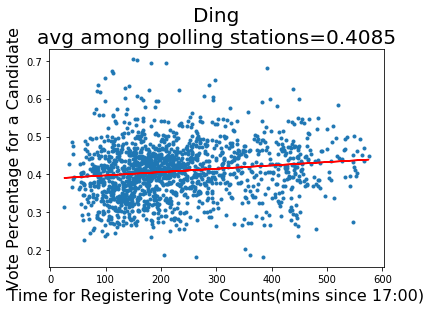

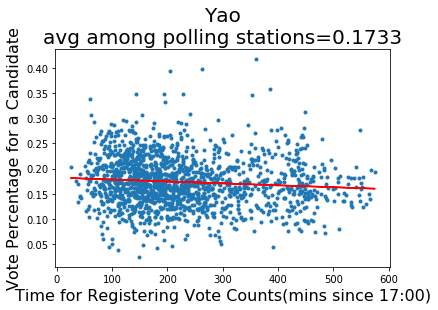

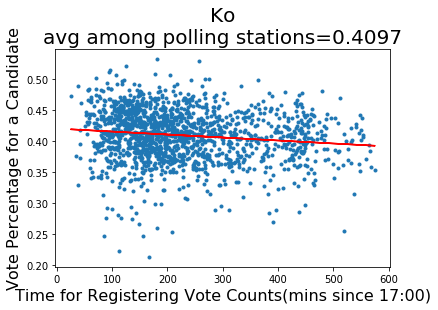

In [146]:
#分別對三位候選人的得票率與投開票所登記票數時間進行迴歸分析及畫圖
for vote_rateskey,vote_ratesvalue in vote_rates.items():
    #olsresults = sm.OLS(vote_ratesvalue,sm.add_constant(register_votes_timetamp)).fit()
    #p = np.polyfit(register_votes_timetamp, vote_ratesvalue, deg=1)
    #print(olsresults.summary())
    #X軸是投開票所的登記票數時間
    plt.xlabel("Time for Registering Vote Counts(mins since 17:00)", fontsize=16)
    #Y軸是特定候選人在投開票所的得票率
    plt.ylabel("Vote Percentage for a Candidate", fontsize=16)
    regr = LinearRegression()
    register_votes_timetamp_for_regr = register_votes_timetamp.reshape(len(register_votes_timetamp), 1)
    regr.fit(register_votes_timetamp_for_regr, vote_ratesvalue)
    linex = register_votes_timetamp_for_regr
    liney = regr.predict(register_votes_timetamp_for_regr)
    plt.plot(register_votes_timetamp, vote_ratesvalue,'.')
    plt.plot(linex, liney, "r")#'--'
    avgrate_vote_rate = str(round(np.average(vote_ratesvalue),4))
    plt.title(vote_rateskey+'\navg among polling stations='+avgrate_vote_rate, fontdict={'fontsize':20})
    plt.show()